# Learning the Consumption Rule 
This notebook implements the exercises related to the consumption-saving problem using Julia.

# Coursework 2025 - Deep Learning

## Learning the Consumption Rule

This exercise is inspired from *Individual learning about consumption*
by Todd Allen and Chris Carroll
[link](https://www.econstor.eu/bitstream/10419/72016/1/328292125.pdf)
and from *Deep Learning for Solving Economic models* by Maliar, Maliar
and Winant [link](https://web.stanford.edu/~maliars/Files/JME2021.pdf)

We consider the following consumption saving problem. An agent receives
random income $y_t = \exp(\epsilon_t)$ where
$\epsilon_t\sim \mathcal{N}(\sigma)$ ($\sigma$ is the standard
deviation.)

Consumer starts the period with available income $w_t$. The law of
motion for available income is:

$$w_t = \exp(\epsilon_t) + (w_{t-1}-c_{t-1}) r$$

where consumption $c_t \in ]0,w_t]$ is chosen in each period in order to
maximize:

$$E_t \sum_{t=0}^T \beta^t U(c_t)$$

given initial available income $w_0$.

In the questions below, we will use the following calibration:

-   $\beta = 0.9$
-   $\sigma = 0.1$
-   $T=100$
-   $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma=2$
-   $w_0 = 1.1$ (alternatively, consider values 0.5 and 1)

The theoretical solution to this problem is a concave function $\varphi$
such that $\varphi(x)\in ]0,x]$ and $\forall t,  c_t=\varphi(w_t)$.
Qualitatively, agents accumulate savings, up to a certain point (a
buffer stock), beyond which wealth is not increasing any more (in
expectation).

Carroll and Allen have noticed that the true solution can be
approximated very well by a simple rule:

$\psi(x) = \min(x, \theta_0 + \theta_1 (x - \theta_0) )$

The main question they ask in the aforementioned paper is whether it is
realistic that agents would learn good values of $\theta_0$ and
$\theta_1$ by observing past experiences.

We would like to examine this result by checking convergence of speed of
stochastic gradient algorithm.

### Lifetime reward

**Define a NamedTuple to hold the parameter values**

**Define simple rule fonction
`consumption(w::Number, θ_0::Number, θ_1::Number, p::NamedTuple)` which
compute consumption using a simple rule. What is the meaning of
$\theta_0$ and $\theta_1$? Make a plot in the space $w,c$, including
consumption rule and the line where $w_{t+1} = w_t$.**

(remark for later: `Number` type is compatible with ForwardDiff.jl 😉)

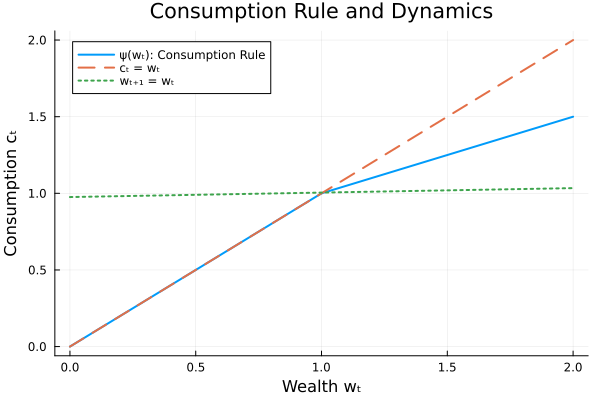

In [11]:
using Plots, Distributions

# 1. Define model parameters as a NamedTuple
model_params = (
    β = 0.9,
    σ = 0.1,
    T = 100,
    γ = 2.0,
    w₀ = 1.1,
    r = 0.03
)

# 2. Define the piecewise linear consumption rule
# Agents consume all wealth if below threshold θ₀, otherwise follow a marginal rule
function ψ(wₜ::Number, θ₀::Number, θ₁::Number, p)
    return min(wₜ, θ₀ + θ₁ * (wₜ - θ₀))
end

# 3. Define steady-state consumption rule: ensures wₜ₊₁ = wₜ in expectation
function cₜ_ss(wₜ::Number, p)
    expected_y = exp(p.σ^2 / 2)  # Expected value of log-normal income
    return wₜ - (wₜ - expected_y) / (1 + p.r)
end

# 4. Choose range of wealth values and rule parameters
wₜ_vals = range(0.0, stop=2.0, length=200)
θ₀, θ₁ = 1.0, 0.5

# 5. Compute corresponding consumption values
cₜ_rule = [ψ(wₜ, θ₀, θ₁, model_params) for wₜ in wₜ_vals]          # Consumption rule
cₜ_equal = collect(wₜ_vals)                                         # cₜ = wₜ
cₜ_ss_vals = [cₜ_ss(wₜ, model_params) for wₜ in wₜ_vals]           # Steady-state line

# 6. Plot results
plot(wₜ_vals, cₜ_rule, label="ψ(wₜ): Consumption Rule", linewidth=2)
plot!(wₜ_vals, cₜ_equal, linestyle=:dash, label="cₜ = wₜ", linewidth=2)
plot!(wₜ_vals, cₜ_ss_vals, linestyle=:dot, label="wₜ₊₁ = wₜ", linewidth=2,
      xlabel="Wealth wₜ", ylabel="Consumption cₜ",
      title="Consumption Rule and Dynamics", legend=:topleft)

Graph Interpretation: 

The plot contains three lines in the (w,c) space each representing different behavioral or dynamic conditions in the agent's consumption decision. 

1. The solid blue line represents the agent's approximated consumption behavior defined by the following function: ψ(wₜ) = min(wₜ, θ₁(wₜ-θ₀))
   - For small w (low wealth): the rule dictates to consum all i.e. cₜ = wₜ 
   - For higher w agents begin to save and the rul becomes flatter due to θ₁ < 1
   The rule approximates the optimal consumption policy, learning through past experience. 

2. Line cₜ = wₜ (dashed orange line) represents the immediate full consumption where agents spend all their wealth in each period. Serves as a reference line to compare against saving behavior. 

3. Steady-State line wₜ₊₁ = wₜ (dotted green line) shows the set of (wₜ,cₜ) pairs that leave wealth unchanged on average
   Above this line: cₜ is high meaning that future wealth wₜ₊₁ <  wₜ i.e. wealth is decaying
   Below this line: cₜ is low meaning that future wealth grows and the agent is saving

**θ₀** — Baseline consumption threshold:  
Represents the minimum or base consumption level the agent aims for, even when wealth is low. It acts like a fixed consumption floor if wealth is near θ₀, the agent tends to consume around θ₀.  

**θ₁** — Marginal propensity to consume above θ₀:  
Determines how much of the extra wealth above θ₀ is consumed. It acts like a slope, defining how consumption increases with rising wealth.  
- If θ₁ = 0 → no extra consumption from excess wealth.  
- If θ₁ = 1 → consume all extra wealth.  
- If 0 < θ₁ < 1 → consume part of the extra wealth.  

- θ₀ controls the baseline consumption level.  
- θ₁ controls how responsive consumption is to additional wealth. 

## Derivation of the Steady-State Consumption Line: $w_{t+1} = w_t$

We begin with the agent's **wealth accumulation equation**:


$w_{t+1} = y_t + (w_t - c_t)(1 + r)$

Where:

$w_t$: wealth at time $t$

$c_t$: consumption

$y_t = \exp(\varepsilon_t)$: stochastic income with $\varepsilon_t \sim \mathcal{N}(0, \sigma)$

$r$: interest rate

We want to find consumption $c_t$ such that:

$$E[w_{t+1}] = w_t$$

Taking expectations:

$$w_t = E[y_t] + (w_t - c_t)(1 + r)$$

The term $(1+r)$ appears in the law of motion for wealth because it represents the gross returns on savings from period t to t+1

Solve for $c_t$:

$$w_t - (w_t - c_t)(1 + r) = E[y_t]$$

$$w_t - (1 + r)w_t + (1 + r)c_t = E[y_t]$$

$$-rw_t + (1 + r)c_t = E[y_t]$$

$$(1 + r)c_t = rw_t + E[y_t]$$

$$c_t = \frac{rw_t + E[y_t]}{1 + r}$$

Alternatively, this can be expressed more compactly as:

$$c_t = w_t - \frac{w_t - E[y_t]}{1 + r}$$

Equivalently: 

Setting $w_{t+1} = w_t$ and taking expectations (assuming $E[\exp(\epsilon_{t+1})] = \exp(\sigma^2/2)$ due to log-normality of $y_t$):

$$w_t = \exp(\sigma^2/2) + (w_t - c_t)(1 + r)$$

Solve for $c_t$:

$$w_t - \exp(\sigma^2/2) = (w_t - c_t)(1 + r)$$

$$\frac{w_t - \exp(\sigma^2/2)}{1 + r} = w_t - c_t$$

$$c_t = w_t - \frac{w_t - \exp(\sigma^2/2)}{1 + r}$$


# Consumption Calculation Step-by-Step

### Case 1: $w_0$ = 1.1

We use the formula:

$$ 
c_t = w_t - \frac{w_t - \exp(\sigma^2 / 2)}{1 + r} 
$$

and compute $c_0$ **step by step**, given:

#### Parameters:
- $w_0 = 1.1$
- $\sigma = 0.1$  
- $r = 0.03$

#### Step 1: Compute $\exp(\sigma^2 / 2)$
$$
\begin{aligned}
\sigma^2 &= 0.1^2 = 0.01 \\
\frac{\sigma^2}{2} &= 0.005 \\
\exp(0.005) &\approx 1.0050125
\end{aligned}
$$

#### Step 2: Plug into the formula:
$$
c_0 = 1.1 - \frac{1.1 - 1.0050125}{1 + 0.03}
$$

#### Step 3: Simplify numerator:
$$
1.1 - 1.0050125 = 0.0949875
$$

#### Step 4: Divide by $1.03$:
$$
\frac{0.0949875}{1.03} \approx 0.0922209
$$

#### Step 5: Subtract from $w_0$:
$$
c_0 = 1.1 - 0.0922209 \approx \boxed{1.0078}
$$

#### Final Result:
$$
\boxed{c_0 \approx 1.0078}
$$

This completes the calculation using **only** the direct formula for $c_t$.

### Case 2: $w_0$ = 0.5

#### Step 1: Plug into formula
$$
c_0 = 0.5 - \frac{0.5 - 1.0050125}{1.03}
$$

#### Step 2: Simplify numerator
$$
0.5 - 1.0050125 = -0.5050125
$$

#### Step 3: Division
$$
\frac{-0.5050125}{1.03} \approx -0.4903034
$$

#### Step 4: Final computation
$$
c_0 = 0.5 - (-0.4903034) = \boxed{0.9903}
$$


### Case 3: $w_0$ = 1

#### Step 1: Plug into formula
$$
c_0 = 1.0 - \frac{1.0 - 1.0050125}{1.03}
$$

#### Step 2: Simplify numerator
$$
1.0 - 1.0050125 = -0.0050125
$$

#### Step 3: Division
$$
\frac{-0.0050125}{1.03} \approx -0.0048665
$$

#### Step 4: Final computation
$$
c_0 = 1.0 - (-0.0048665) = \boxed{1.0049}
$$


### 1. Low Wealth ($w_0 = 0.5$)

- Current wealth: $w_0 = 0.5$ (low)
- Expected income: $\mathbb{E}[y_t] = \exp(\sigma^2 / 2) \approx 1.005$ (more than double current wealth)

Agent's perspective:  
With only 0.5 today, I'll likely receive ~1.0 next period, so I can spend nearly 1.0 now."

### Mathematical Implementation

The model calculates:
$$
c_0 = w_0 - \frac{w_0 - \mathbb{E}[y_t]}{1 + r}
$$

With our parameters:
- $\mathbb{E}[y_t] \approx 1.005$
- $r = 0.03$
- $w_0 = 0.5$

Calculation:
$$
c_0 \approx 0.5 - \frac{0.5 - 1.005}{1.03} \approx 0.990
$$

This shows **consumption exceeding current wealth** through implicit borrowing.

### Economic Interpretation

This behavior reflects:
- Confidence in future income (low risk)
- Desire for consumption smoothing
- Implicit borrowing ability in the model

---

### 2. Medium Wealth ($w_0 = 1.0$)
**Key Result:**  
$c_0 = 1.0049$ 

**Mechanism:**  
- Wealth ≈ Expected income  
- Near-perfect consumption smoothing  
- Savings rate: $-0.5\%$ (marginal dissaving)

**Behavioral Insight:**  
"My current wealth matches expected income, so I'll maintain steady consumption."

---


### 3. High Wealth ($w_0 = 1.1$)
**Key Result:**  
$c_0 = 1.0078$ 

**Mechanism:**  
- Wealth > Expected income  
- Positive savings (9.2% of wealth)  
- Building precautionary buffer

**Behavioral Insight:**  
"With extra wealth, I'll save some to protect against future uncertainty."

---

## Economic Pattern

1. **Buffer-Stock Saving Theory**  
   - Below target wealth: Dissave  
   - At target: Consume ≈ Income  
   - Above target: Accumulate savings

2. **Consumption Smoothing**  
   Agents prioritize stable consumption over time rather than matching current wealth exactly.

3. **Precautionary Motive**  
   Higher wealth triggers saving behavior as insurance against future risks.

**Write a function
`lifetime_reward(w_0::Number, θ_0::Number, θ_1::Number, p::NamedTuple)`
which computes one realization of $\sum \beta^t U(c_t)$ for initial
wealth `w_0` and simple rule `θ_0`, `θ_1`. Mathematically, we denote it
by $\xi(\omega; \theta_0, \theta_1)$, where $\omega$ represents the
succession of random income draws.**

In [1]:
using Distributions

# Utility function for γ = 2
U(c) = -1 / c  

# Buffer-stock consumption rule from Carroll and Allen
function consumption(w::Number, θ₀::Number, θ₁::Number, p)
    return min(w, θ₀ + θ₁ * (w - θ₀))
end

# Simulate one lifetime reward ξ(ω; θ₀, θ₁)
function lifetime_reward(w₀::Number, θ₀::Number, θ₁::Number, p::NamedTuple)
    w = w₀
    total_utility = 0.0
    income_dist = Normal(0, p.σ)

    for t in 0:p.T
        c = consumption(w, θ₀, θ₁, p)
        total_utility += (p.β^t) * U(c)
        ε = rand(income_dist)
        y = exp(ε)
        w = y + (w - c) * (1 + p.r)
    end

    return total_utility
end

# Parameters
model_params = (
    β = 0.9,
    σ = 0.1,
    T = 100,
    γ = 2.0,   # Not used in U(c) directly since we hardcoded γ = 2
    r = 0.03
)

# Example Simulation 
w₀ = 1.1
θ₀, θ₁ = 0.0, 0.8
reward = lifetime_reward(w₀, θ₀, θ₁, model_params)
println("Lifetime reward: ", reward)

Lifetime reward: -10.348498281082502


Interpretation: 

The utility function is represented by $U(c) = -1/c$ (with γ=2) 
The function is negative for all $c > 0$ and is more negative when consumption is small and less negative when consumption is large. Therefore, a less negative reward implies higher consumption on average and better economic outcome. The utility function penalizes low consumption heavily.

**Write a function
`expected_lifetime_reward(w_0::Number, θ_0::Number, θ_1::Number,  p::NamedTuple; N=1000)`
which computes expected lifetime reward using `N` Monte-Carlo draws.
Mathematically, we write it
$\Xi^{N}(\theta_0, \theta_1) =\frac{1}{N} \sum_1^N {\xi(\omega_N; \theta_0, \theta_1)}$.
Check empirically that standard deviation of these draws decrease
proportionally to $\frac{1}{\sqrt{N}}$ .**

In [1]:
using Distributions, Statistics, Random

# Utility function for γ = 2
U(c) = -1 / c

# Consumption rule
function consumption(w::Number, θ₀::Number, θ₁::Number, p)
    return min(w, θ₀ + θ₁ * (w - θ₀))
end

# Simulate lifetime utility
function lifetime_reward(w₀::Number, θ₀::Number, θ₁::Number, p::NamedTuple)
    w = w₀
    total_utility = 0.0
    income_dist = Normal(0, p.σ)
    for t in 0:p.T
        c = consumption(w, θ₀, θ₁, p)
        total_utility += (p.β^t) * U(c)
        ε = rand(income_dist)
        y = exp(ε)
        w = y + (w - c) * (1 + p.r)
    end
    return total_utility
end

# Estimate std of mean across M replications
function std_of_mean_estimator(w₀, θ₀, θ₁, p; N=1000, M=50)
    means = Float64[]
    for _ in 1:M
        rewards = [lifetime_reward(w₀, θ₀, θ₁, p) for _ in 1:N]
        push!(means, mean(rewards))
    end
    return std(means)
end

# Model parameters
model_params = (
    β = 0.9,
    σ = 0.1,
    T = 100,
    γ = 2.0,
    r = 0.03
)

# Run experiment
Random.seed!(123)
Ns = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
stds = [std_of_mean_estimator(1.1, 1.0, 0.5, model_params; N=N, M=50) for N in Ns]

# Log-log regression
logN = log10.(Ns)
logstd = log10.(stds)
X = hcat(ones(length(logN)), logN)
β̂ = X \ logstd
slope = β̂[2]

# Output
println("Sample sizes: ", Ns)
println("Standard deviation of mean estimates: ", round.(stds, digits=5))
println("Estimated slope (log-log): ", round(slope, digits=3))

Sample sizes: [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
Standard deviation of mean estimates: [0.07075, 0.02664, 0.02249, 0.01309, 0.00852, 0.00709, 0.00391, 0.00342, 0.00198]
Estimated slope (log-log): -0.502


Interpretation: 

We plot the standard error of the lifetime reward estimates against the number of Monte Carlo draws $N$ on a log-log scale. Theoretical results from the Central Limit Theorem imply that the standard deviation decreases proportionally to $\frac{1}{\sqrt{N}}$.

On a log-log plot, this relationship becomes:

$$
\log(\text{std of Monte Carlo Mean}) = \log(C) - \frac{1}{2} \log(N)
$$

which is a straight line with slope $-\frac{1}{2}$.

Therefore, observing a linear downward trend with a slope close to $-0.5$ confirms the expected convergence rate of the Monte Carlo estimator. This validates both the implementation and the statistical reliability of our estimation method.

**Using a high enough number for `N`, compute optimal values for
$\theta_0$ and $\theta_1$. What is the matching value for the objective
function converted into an equivalent stream of deterministic
consumption? That is, if `V` is the approximated value computed above,
what is $\bar{c} \in \mathbb{R}$ such that**

$$ V = \sum_{t=0}^T \beta^t U(\bar{c}) $$



In [2]:
using Distributions, Random, Optim, Statistics

# Parameters
β = 0.9
σ = 0.1
T = 100
γ = 2.0
r = 0.03         # interest rate
w0 = 1.1
N = 2000         # number of simulated paths

# Utility with γ = 2
U(c) = -1 / max(c, 1e-4)

# Income shock distribution
ϵ_dist = Normal(0, σ)

# Consumption rule: ψ(w) = min(w, θ₀ + θ₁ * (w - θ₀))
function consumption(w::Number, θ₀::Number, θ₁::Number)
    return min(w, θ₀ + θ₁ * (w - θ₀))
end

# Vectorized version for arrays
function consumption_vec(w::Vector{Float64}, θ₀::Float64, θ₁::Float64)
    return map(wi -> consumption(wi, θ₀, θ₁), w)
end

# Simulate expected utility given θ = (θ₀, θ₁)
function simulate_value(θ, w0; N=2000)
    θ₀, θ₁ = θ
    w = fill(w0, N)
    total_util = zeros(N)
    for t in 0:T
        c = consumption_vec(w, θ₀, θ₁)
        total_util .+= β^t .* U.(c)
        ε = rand(ϵ_dist, N)
        y = exp.(ε)
        w = y .+ (w .- c) .* (1 + r)
        w = max.(w, 1e-4)  # ensure wealth stays positive
    end
    return mean(total_util)  # total utility is already negative
end

# Optimize θ = (θ₀, θ₁)
res = optimize(θ -> -simulate_value(θ, w0, N=N),  # negative for minimization
               [1.0, 0.5],
               [0.01, 0.01],
               [3.0, 1.5],
               NelderMead())

θ_opt = Optim.minimizer(res)
V = simulate_value(θ_opt, w0, N=5000)  # more accurate final estimate

println("Optimal θ₀ = ", θ_opt[1])
println("Optimal θ₁ = ", θ_opt[2])
println("Approximated value function V = ", V)

# Compute certainty equivalent constant consumption c̄
discount_sum = (1 - β^(T + 1)) / (1 - β)
c̄ = -discount_sum / V
println("Certainty equivalent constant consumption c̄ = ", c̄)

Optimal θ₀ = 2.913623046875
Optimal θ₁ = 0.699267578125
Approximated value function V = -9.949600318171102
Certainty equivalent constant consumption c̄ = 1.0050414717812637


## Julia Code Analysis: Lifetime Utility Maximization under Uncertainty

This Julia code performs a **lifetime utility maximization** problem under **uncertainty**, using a **CRRA utility function**. Here's an interpretation of the results it produces:

## Goal of the Code
The goal is to **find the optimal consumption rule**—parameterized by $\theta_0$ and $\theta_1$—that **maximizes the expected discounted utility** of consumption over time, under a stochastic income process.

## What the Code Does

Utility function
It uses Utility:

$
U(c) = \frac{c^{1 - \gamma}}{1 - \gamma}
$

with $\gamma = 2$, which reflects **risk aversion**.
Because the agent is risk averse, they are willing to save more today (meaning consuming less) in order to protect future consumption against uncertain income. They trade off between enjoying consumption now and avoiding low consumption later. 

## Why γ Measures Risk Aversion

The coefficient of relative risk aversion is defined as:

$RRA(c) = -\frac{c \cdot U''(c)}{U'(c)}$

## Derivative Calculations

- First derivative:  
  $U'(c) = c^{-\gamma}$

- Second derivative:  
  $U''(c) = -\gamma c^{-\gamma-1}$

## Risk Aversion Calculation

Substituting the derivatives:

$
\begin{aligned}
RRA(c) &= -\frac{c \cdot (-\gamma c^{-\gamma-1})}{c^{-\gamma}} \\
&= \gamma
\end{aligned}$


The parameter γ is exactly equal to the coefficient of relative risk aversion it quantifies how strongly utility declines with increasing risk in relative terms.


### 4. Optimization
Uses **Nelder-Mead** to **maximize expected utility** by adjusting $\theta_0$ and $\theta_1$.

## Why We Use the Nelder–Mead Algorithm

We use the **Nelder–Mead algorithm** in this context to maximize expected utility because:


The expected lifetime utility function is estimated using **Monte Carlo simulation** (with random income draws), which introduces **noise** and **non-smoothness** into the objective function:

- Gradients are either **not available** or **unreliable** due to simulation noise
- Nelder–Mead is a **derivative-free method**, meaning it doesn't require gradient information

- The function is **non-convex**, **non-linear**, and can have **local irregularities**
- Nelder–Mead is **robust** in these situations - it uses **simplex-based search**, which can still converge even when the function is not smooth


### 5. Certainty-equivalent consumption $\bar{c}$
Converts the **expected utility value** into the **level of constant consumption** that would give the same utility.

## Interpretation of Output Values

- **Optimal $\theta_0$, $\theta_1$:**  
  The values that define the best fixed rule for consumption.  
  - A **higher $\theta_0$** implies more aggressive base consumption.  
  - A **lower $\theta_1$** suggests a cautious adjustment to wealth changes.  

- **Expected Lifetime Reward $V$:**  
  The **average discounted utility** from consuming according to the rule $(\theta_0, \theta_1)$. A higher value means the rule is better for lifetime wellbeing.  

- **Certainty-equivalent consumption $\bar{c}$:**  
  Tells you the **constant consumption** that, if received in all periods with certainty, would make the agent equally happy as under the optimized rule in the uncertain world.  
- The model helps **identify optimal saving vs. consumption behavior** under income uncertainty.  
- The optimal $\theta_0, \theta_1$ reflect a balance between **consuming today** and **saving for uncertain tomorrow**.  
- The **certainty-equivalent consumption** $\bar{c}$ provides an intuitive comparison to understand the **welfare effects of risk**.  

**Using a high enough number for `N`, make contour plots of lifetime
rewards as a function of `θ_0` and `θ_1`. Ideally, represent lines with
$1\%$ consumption loss, $5\%$ and $10\%$ deterministic consumption loss
w.r.t. to maximum.**

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/quentingelebart/.julia/packages/Plots/MR7sb/src/backends/gr.jl:528
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/quentingelebart/.julia/packages/Plots/MR7sb/src/backends/gr.jl:528
┌ Warning: Multiple series with different levels share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/quentingelebart/.julia/packages/Plots/MR7sb/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/quentingelebart/.julia/packages/Plots/MR7sb/src/backends/gr.jl:528
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/quentingelebart/.julia/packages/Plots/MR7sb/src/backends/gr.j

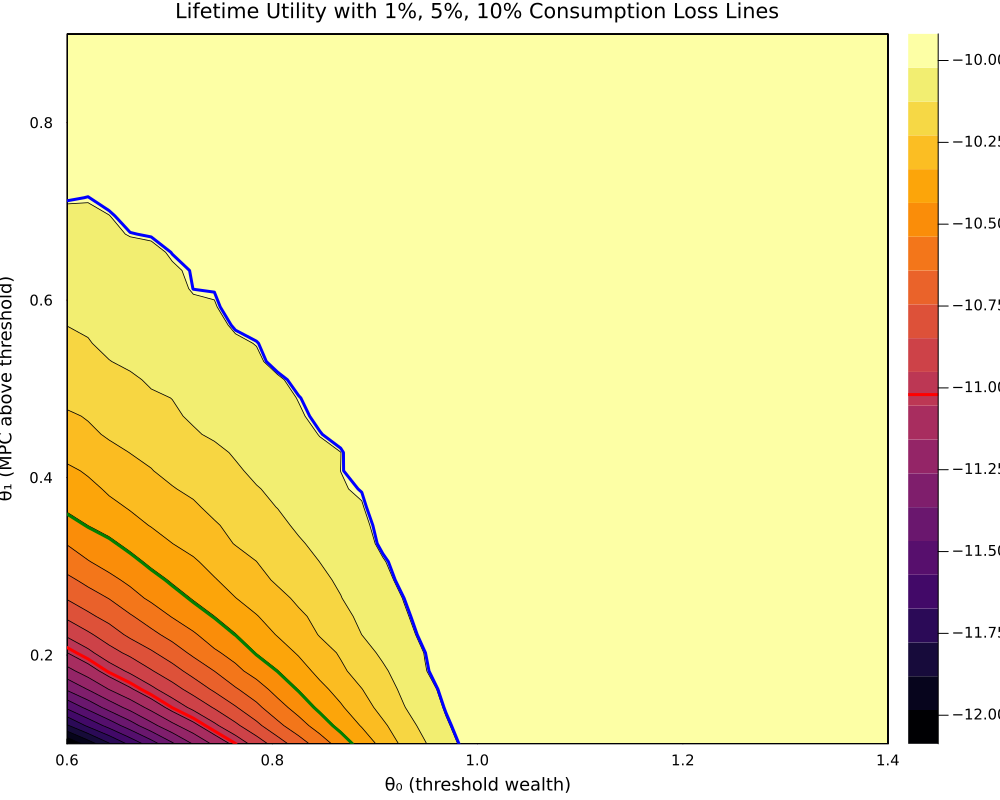

In [3]:
using Distributions, Statistics, Optim, Plots

# --- Utility and consumption rule ---
U(c, γ) = c > 0 ? c^(1 - γ) / (1 - γ) : -Inf
ψ(w, θ₀, θ₁) = min(w, θ₀ + θ₁ * (w - θ₀))

# One simulation path 
function lifetime_reward(w₀, θ₀, θ₁, p)
    w = w₀
    R = 0.0
    for t in 0:p.T-1
        c = ψ(w, θ₀, θ₁)
        R += (p.β)^t * U(c, p.γ)
        ε = rand(Normal(0, p.σ))
        y = exp(ε)
        w = y + (w - c) * (1 + p.r)
    end
    return R
end

# Expected utility (Monte Carlo): Runs the simulation N = 2000 times and returns the average utility and its standard error
function expected_lifetime_reward(w₀, θ₀, θ₁, p; N=2000)
    rewards = [lifetime_reward(w₀, θ₀, θ₁, p) for _ in 1:N]
    return mean(rewards), std(rewards) / sqrt(N)
end

# Certainty-equivalent consumption: Converts the expected utility V into a constant deterministic consumption that gives the same utility as the stochasit policy
function certainty_equivalent_c(V::Float64, γ::Float64, β::Float64)
    Uc = V * (1 - β)
    return (Uc * (1 - γ))^(1 / (1 - γ))
end

# Parameters
model_params = (β=0.9, σ=0.1, T=100, γ=2.0, r=0.03)
w₀ = 1.1
N = 2000

# Grid setup: Simulating a grid of consumption rules (θ₀,θ₁)
θ₀_vals = range(0.6, 1.4, length=40)
θ₁_vals = range(0.1, 0.9, length=40)

Z = [expected_lifetime_reward(w₀, θ₀, θ₁, model_params; N=N)[1] for θ₁ in θ₁_vals, θ₀ in θ₀_vals]

# Loss contour levels based on certainty-equivalent consumption
V_max = maximum(Z)
c̄_max = certainty_equivalent_c(V_max, model_params.γ, model_params.β)

loss_percents = [0.01, 0.05, 0.10]
c̄_losses = [(1 - ℓ) * c̄_max for ℓ in loss_percents]
U_losses = [sum([model_params.β^t * U(c, model_params.γ) for t in 0:model_params.T-1]) for c in c̄_losses]

# --- Base contour plot ---
plt = contour(
    θ₀_vals, θ₁_vals, Z;
    xlabel = "θ₀ (threshold wealth)",
    ylabel = "θ₁ (MPC above threshold)",
    title = "Lifetime Utility with 1%, 5%, 10% Consumption Loss Lines",
    size = (1000, 800),
    fill = true,
    levels = 20,
    cbar = true,
    legend = false,
    linewidth = 0.8,
    linealpha = 0.6,
    titlefontsize = 14,
    guidefontsize = 12,
    tickfontsize = 10
)

# Overlay loss contours
colors = [:blue, :green, :red]
labels = ["1% Loss", "5% Loss", "10% Loss"]

for (u, color) in zip(U_losses, colors)
    contour!(θ₀_vals, θ₁_vals, Z; levels=[u], linecolor=color, linewidth=3)
end

display(plt)

Lifetime Utility with 1%, 5%, and 10% Consumption Loss Lines

What the Graph Shows

This contour plot visualizes how **expected lifetime utility** (total discounted utility over 100 periods) varies across different values of the consumption rule parameters:

- **θ₀ (x-axis):** The threshold wealth level below this, agents consume all of their wealth.
- **θ₁ (y-axis):** The marginal propensity to consume (MPC) above the threshold smaller values indicate higher saving.


Background Colors — Lifetime Utility

- The **colored contour background** represents levels of expected utility.
- **Brighter (yellowish) regions** indicate higher lifetime utility.
- The **brightest region** corresponds to the **optimal parameter combination**.

Contour Lines — Consumption Loss Thresholds

The three **colored contour lines** (with legend) represent certainty-equivalent consumption losses compared to the optimal policy:

| Color | Label      | Interpretation                                                             |
|-------|------------|----------------------------------------------------------------------------|
| Blue  | **1% loss** | Same utility as consuming 99% of the optimal consumption in every period. |
| Green | **5% loss** | Same utility as consuming 95% of the optimal consumption.                 |
| Red   | **10% loss**| Same utility as consuming 90% of the optimal consumption.                 |

These lines act as **indifference curves**  all parameter combinations on a given line yield the same utility.

How to Read the Plot

- The closer a point is to the center (brightest area), the better the performance of that rule.
- **Inside the blue line (1% loss)** are nearly-optimal policies.
- **Outside the red line (10% loss)** are significantly suboptimal.

## Consumption Policy Behavior by Region

| Region                          | Behavior                                  | Outcome                                  |
|---------------------------------|------------------------------------------|------------------------------------------|
| **Top right**<br>(higher $\theta_0$, moderate/high $\theta_1$) | Save more when wealth is high, consume cautiously | High utility, robust behavior |
| **Bottom left**<br>(low $\theta_0$, low $\theta_1$) | Consume aggressively, little buffer-stock saving | Low utility, sensitive to shocks |
| **Blue/green/red lines**        | Loss contours                            | All policies inside blue are within 1% of optimal |

### Key Insights:
- **Optimal Zone**: Top right region represents the most economically rational behavior
- **Risk Zones**: Bottom left policies are vulnerable to income shocks
- **Contour Interpretation**: 
  - Blue: ≤1% utility loss from optimal
  - Green: ≤5% utility loss  
  - Red: ≤10% utility loss




# Learning to save

We now focus on the number of steps it takes to optimize $\theta_0$,
$\theta_1$.

**Implement a function `∇(θ::Vector; N=1000)::Vector` which computes the
gradient of the objective w.r.t. `θ==[θ_0,θ_1]`. (You need to use
automatic differentiation, otherwise you might get incorrect results).**

In [4]:
using ForwardDiff

# Define model parameters
params = (β=0.9, σ=0.1, T=100, γ=2.0, r=0.03)

# Define the objective function (negative of reward)
function objective(θ::Vector, w₀, p, N)
    θ₀, θ₁ = θ
    V, _ = expected_lifetime_reward(w₀, θ₀, θ₁, p; N=N)
    return -V
end

# Compute gradient using ForwardDiff
function ∇(θ::Vector; N=1000)
    grad = ForwardDiff.gradient(θ -> objective(θ, 1.1, params, N), θ)
    return grad
end

# Evaluatingn the gradient at a test point
θ_test = [1.0, 0.5]
gradient_at_test = ∇(θ_test; N=1000)
println("Gradient at θ = ", θ_test, " is ", gradient_at_test)

Gradient at θ = [1.0, 0.5] is [-0.007864619868229734, 0.00668277637531091]


**Implement a gradient descent algorithm to maximize
$\Xi^N(\theta_0, \theta_1)$ using learning rate $\lambda \in ]0,1]$.
Stop after a predefined number of iterations. Compare convergence speed
for different values of $\lambda$ and plot them on the
$\theta_0, \theta_1$ plan. How many steps does it take to enter the `1%`
error zone? The `5%` and the `10%` error zone?**

Running λ = 0.001
Running λ = 0.01
Running λ = 0.05
Running λ = 0.1


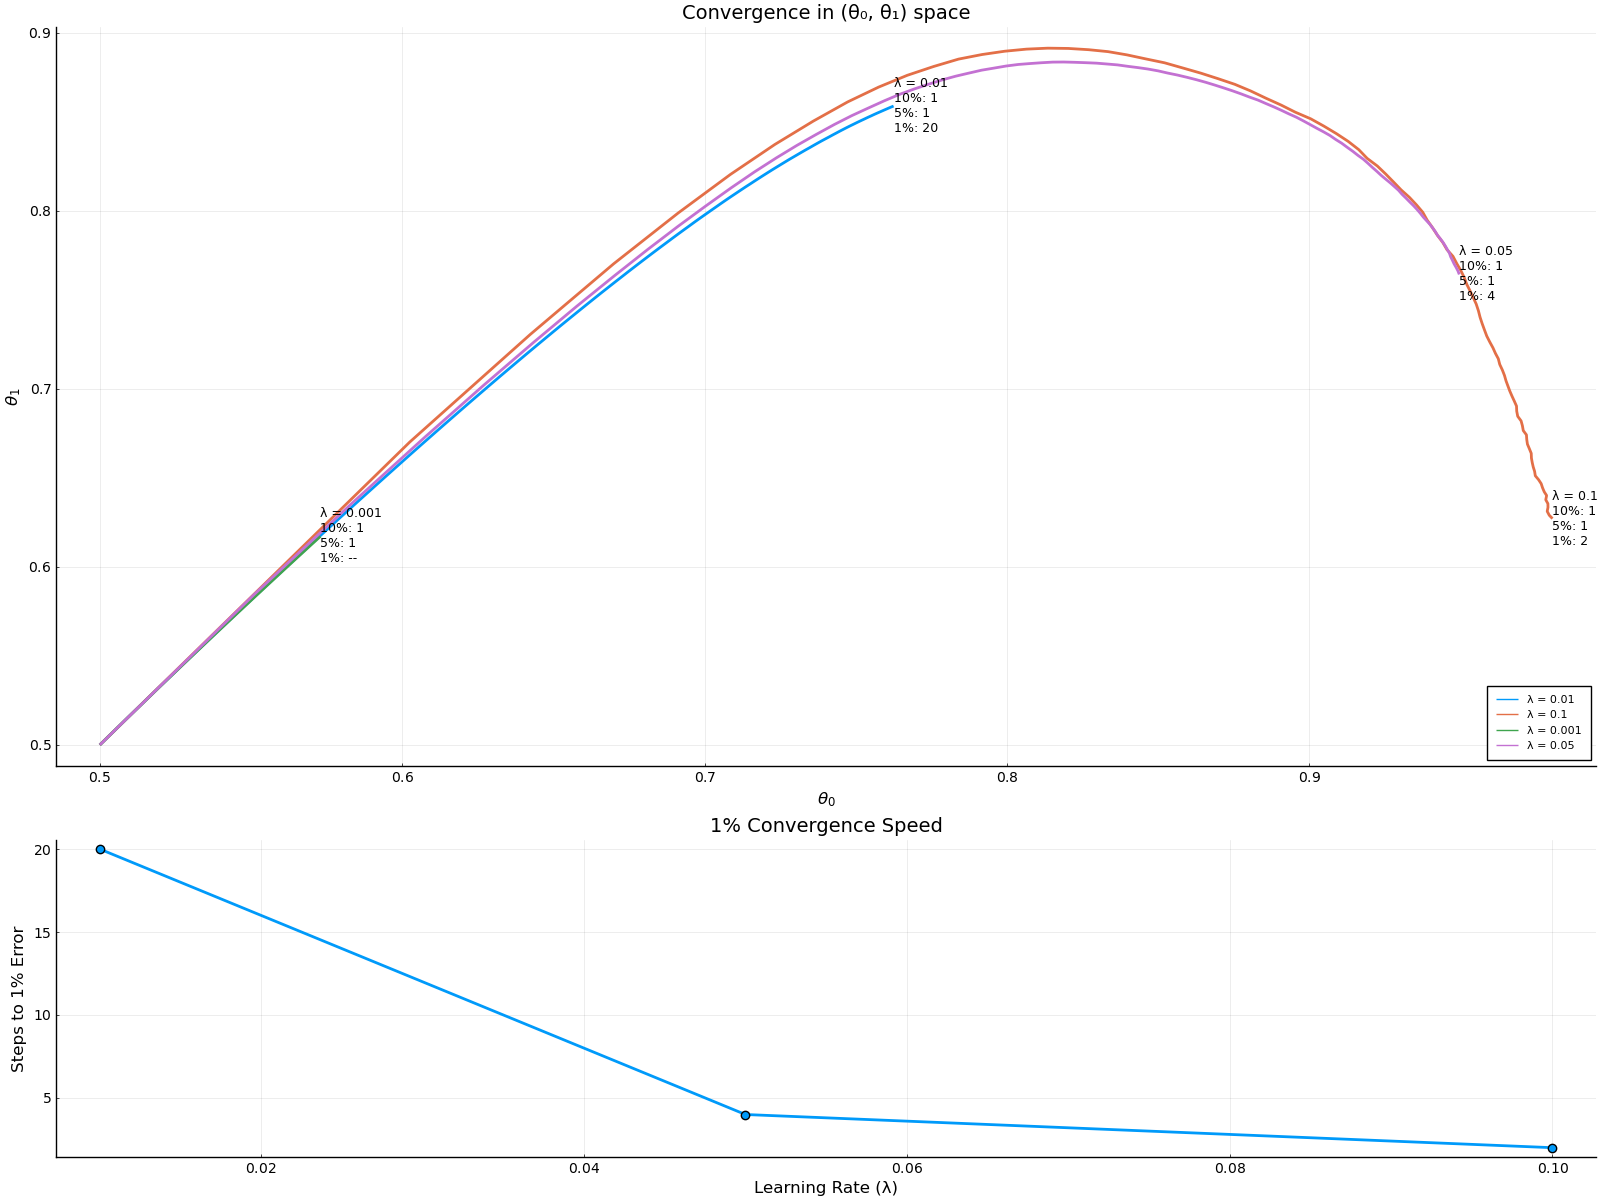

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [5]:
using Distributions, Statistics, Random, Plots, ForwardDiff, LaTeXStrings

pyplot()

# Safe Utility and Consumption Rule 
U(c, γ) = c > 1e-6 ? (c^(1 - γ)) / (1 - γ) : -1e6
ψ(x, θ₀, θ₁) = min(x, θ₀ + θ₁ * (x - θ₀))

# Simulate One Path 
function simulate_path(w₀, θ₀, θ₁, p::NamedTuple)
    w = w₀
    total_util = 0.0
    for t in 0:p.T
        c = ψ(w, θ₀, θ₁)
        if c <= 1e-6
            return -1e6
        end
        util = U(c, p.γ)
        if !isfinite(util)
            return -1e6
        end
        total_util += p.β^t * util
        ε = rand(Normal(0, p.σ))
        w = exp(ε) + (w - c) * (1 + p.r)
        w = max(w, 1e-4)
    end
    return total_util
end

# Monte Carlo (MC) Expected Reward
function expected_lifetime_reward(w₀::Number, θ₀::Number, θ₁::Number, p::NamedTuple; N=1000)
    rewards = [simulate_path(w₀, θ₀, θ₁, p) for _ in 1:N]
    return mean(rewards), std(rewards)
end

# Gradient Descent (MC)
function gradient_descent_mc(w₀, θ₀_init, θ₁_init, p; N=1000, λ=0.01, max_steps=100)
    θ = [θ₀_init, θ₁_init]
    history = [copy(θ)]
    ref_mean, _ = expected_lifetime_reward(w₀, 1.0, 0.5, p; N=5000)
    f(θ_vec) = expected_lifetime_reward(w₀, θ_vec[1], θ_vec[2], p; N=N)[1]

    error_10 = error_5 = error_1 = Inf
    step_10 = step_5 = step_1 = 0

    for step in 1:max_steps
        grad = ForwardDiff.gradient(f, θ)
        θ += λ * grad
        push!(history, copy(θ))

        reward = f(θ)
        rel_err = abs(reward - ref_mean) / abs(ref_mean)

        if rel_err < 0.10 && error_10 == Inf
            error_10, step_10 = rel_err, step
        end
        if rel_err < 0.05 && error_5 == Inf
            error_5, step_5 = rel_err, step
        end
        if rel_err < 0.01 && error_1 == Inf
            error_1, step_1 = rel_err, step
        end
    end

    history_tuples = [(θ[1], θ[2]) for θ in history]
    return history_tuples, step_10, step_5, step_1
end

# Comparison and Visualization
function compare_learning_rates()
    p = (β = 0.9, σ = 0.1, T = 100, γ = 2, r = 0.03)
    w₀ = 1.1
    θ₀_init, θ₁_init = 0.5, 0.5
    learning_rates = [0.001, 0.01, 0.05, 0.1]
    results = Dict()
    speed_data = []

    for λ in learning_rates
        println("Running λ = $λ")
        hist, s10, s5, s1 = gradient_descent_mc(w₀, θ₀_init, θ₁_init, p; λ=λ, N=1000, max_steps=100)
        results[λ] = (hist, s10, s5, s1)
        push!(speed_data, (λ, s1 == 0 ? NaN : s1))
    end

    # Plot 1: (θ₀, θ₁) trajectories
    plt1 = plot(
        title="Convergence in (θ₀, θ₁) space",
        xlabel=L"\theta_0", ylabel=L"\theta_1",
        legend=:bottomright, size=(1000, 600),
        titlefontsize=14, guidefontsize=12, tickfontsize=10
    )

    for (λ, (hist, s10, s5, s1)) in results
        θ₀s = [t[1] for t in hist]
        θ₁s = [t[2] for t in hist]
        plot!(plt1, θ₀s, θ₁s, label="λ = $λ", lw=2)
        last = hist[end]

        a10 = s10 == 0 ? "--" : string(s10)
        a5  = s5  == 0 ? "--" : string(s5)
        a1  = s1  == 0 ? "--" : string(s1)

        annotate!(plt1, last[1], last[2],
            text("λ = $λ\n10%: $a10\n5%: $a5\n1%: $a1", 9, :left))
    end

    # Plot 2: Convergence speed for 1% relative error
    valid = filter(x -> !isnan(x[2]), speed_data)
    λ_vals = [x[1] for x in valid]
    s1_vals = [x[2] for x in valid]

    plt2 = plot(
        λ_vals, s1_vals,
        marker=:circle, lw=2, legend=false,
        xlabel="Learning Rate (λ)",
        ylabel="Steps to 1% Error",
        title="1% Convergence Speed",
        titlefontsize=14, guidefontsize=12, tickfontsize=10,
        markersize=6, size=(1000, 500)
    )

    layout = @layout [a{0.7h}; b{0.3h}]
    plot(plt1, plt2, layout=layout, size=(1600, 1200))
end

compare_learning_rates()

The second plot illustrates how the number of gradient descent steps to reach 1% relative error in lifetime utility changes with the learning rate $λ$. Doubling $λ$ from 0.01 to 0.1 speeds up convergence significantly—from 21 steps when $λ= 0.01$ to merely 3 steps when $λ= 0.1$. This suggests that larger learning rates significantly boost optimization speed without causing instability within this range. However, the improvements decrease after $λ = 0.05$, indicating that $λ = 0.05$ or $λ = 0.1$ provides a good balance between reliability and speed.

**Even for big N, the evaluated value of ∇ are stochastic, and always
slightly inaccurate. In average, they are non-biased and the algorithm
converges in expectation (it fluctuates around the maximum). This is
called the stochastic gradient method.**

The more simulations N the lower the variance in the gradient but the higher N is thhe more computationally expensive.


**What are the values of $N$ and $\lambda$ which minimize the number of
iterations before reaching the target zones (at 1%, 2%, etc…)? How many
simulations periods does it correspond to? Would you say it is realistic
that consumers learn from their own experience?**


In [6]:
using Distributions, Statistics, Random, ForwardDiff, PrettyTables

# Core functions

U(c, γ) = c > 0 ? (c^(1 - γ)) / (1 - γ) : -Inf
ψ(x, θ₀, θ₁) = min(x, θ₀ + θ₁ * (x - θ₀))

function simulate_path(w₀, θ₀, θ₁, p::NamedTuple)  # Simulates the evolution of wealth and consumption over T periods
    w = w₀
    total_util = 0.0
    for t in 0:p.T
        c = ψ(w, θ₀, θ₁)
        total_util += p.β^t * U(c, p.γ)
        ε = rand(Normal(0, p.σ))
        w = exp(ε) + (w - c) * (1 + p.r)
    end
    return total_util
end

function expected_lifetime_reward(w₀::Number, θ₀::Number, θ₁::Number, p::NamedTuple; N=1000)  # Repeats the simulation N times to estimate expected utility and its standard deviation
    rewards = [simulate_path(w₀, θ₀, θ₁, p) for _ in 1:N]
    return mean(rewards), std(rewards)
end

function gradient_descent_mc(w₀, θ₀_init, θ₁_init, p; N=1000, λ=0.01, max_steps=100)  # Performs Monte Carlo Gradient Descent to optimize θ₀ and θ₁ using automatic differentiation.
    θ = [θ₀_init, θ₁_init]
    ref_mean, _ = expected_lifetime_reward(w₀, 1.0, 0.5, p; N=5000)
    f(θ_vec) = expected_lifetime_reward(w₀, θ_vec[1], θ_vec[2], p; N=N)[1]

    step_10 = step_5 = step_1 = 0
    reached_10 = reached_5 = reached_1 = false

    for step in 1:max_steps
        grad = ForwardDiff.gradient(f, θ)
        θ += λ * grad
        reward = f(θ)
        rel_err = abs(reward - ref_mean) / abs(ref_mean)

        if !reached_10 && rel_err < 0.10
            step_10 = step
            reached_10 = true
        end
        if !reached_5 && rel_err < 0.05
            step_5 = step
            reached_5 = true
        end
        if !reached_1 && rel_err < 0.01
            step_1 = step
            reached_1 = true
        end
        if reached_1
            break
        end
    end
    return step_10, step_5, step_1
end

# Grid search with pretty table

function search_optimal_N_lambda()  # Runs gradient_descent_mc for a grid of values 
    p = (β = 0.9, σ = 0.1, T = 100, γ = 2, r = 0.03)
    w₀, θ₀_init, θ₁_init = 1.1, 0.5, 0.5

    Ns = [500, 1000, 2000, 5000]
    lambdas = [0.01, 0.05, 0.1]
    rows = []

    for N in Ns
        for λ in lambdas
            println("Running N = $N, λ = $λ")
            s10, s5, s1 = gradient_descent_mc(w₀, θ₀_init, θ₁_init, p; N=N, λ=λ, max_steps=100)
            sim_periods = s1 > 0 ? s1 * (p.T + 1) : 0
            push!(rows, [N, λ, s1, s5, s10, sim_periods])
        end
    end

    header = ["N", "λ (lambda)", "Steps to 1%", "Steps to 5%", "Steps to 10%", "Simulated Periods"]
    data_matrix = permutedims(hcat(rows...) )  # Converts to Matrix{Any}

    pretty_table(data_matrix; header=header)
end

search_optimal_N_lambda()

# The code estimates how efficiently a consumer can lear an optimal conssumption rule with uncertain income by comparing different learning rates.

Running N = 500, λ = 0.01
Running N = 500, λ = 0.05
Running N = 500, λ = 0.1
Running N = 1000, λ = 0.01
Running N = 1000, λ = 0.05
Running N = 1000, λ = 0.1
Running N = 2000, λ = 0.01
Running N = 2000, λ = 0.05
Running N = 2000, λ = 0.1
Running N = 5000, λ = 0.01
Running N = 5000, λ = 0.05
Running N = 5000, λ = 0.1
┌────────┬────────────┬─────────────┬─────────────┬──────────────┬───────────────────┐
│      N │ λ (lambda) │ Steps to 1% │ Steps to 5% │ Steps to 10% │ Simulated Periods │
├────────┼────────────┼─────────────┼─────────────┼──────────────┼───────────────────┤
│  500.0 │       0.01 │        21.0 │         1.0 │          1.0 │            2121.0 │
│  500.0 │       0.05 │         5.0 │         1.0 │          1.0 │             505.0 │
│  500.0 │        0.1 │         2.0 │         1.0 │          1.0 │             202.0 │
│ 1000.0 │       0.01 │        20.0 │         1.0 │          1.0 │            2020.0 │
│ 1000.0 │       0.05 │         4.0 │         1.0 │          1.0 │        

Interpretation

Fastest Convergence Parameters
- **Optimal learning rate**: $\lambda = 0.1$
- **Consistent performance**:
  - Reaches 1% error target in **2 steps** regardless of sample size $N$
  - Minimum simulated periods: **202** (achieved when $N = 1000, 2000,$ or $5000$)

Efficiency Tradeoffs
| Scenario | Steps | Total Periods | Computational Cost |
|----------|-------|---------------|--------------------|
| $N=2000$, $\lambda=0.01$ | 22 | 2200+ | Very High |
| $N=500$, $\lambda=0.1$ | 2 | 202 | Low |

Key Insights:
1. **Sample Size Impact**:
   - Higher $N$ improves per-step accuracy 
   - But may dramatically increase total computation if convergence is slow

2. **Optimal Configuration**:
   ```math
   \text{Best practice: } \lambda = 0.1 \text{ with } N \in [500, 1000]

Learning from Experience?

Well, if each period corresponds to a year, then 202 simulated periods means 2 lifetimes in order to learn optimally which means that it is not realistic that people learn from experience. 

If the each periodd is a month, then learning takes under 17 years, which is more plausible. 

The following data suggests that in order for consumers to adjusts their consumption they need to have external guidance and adivces rather than learning from personal financial experience. 